# NLP501 - NATURAL LANGUAGE PROCESSING

# EXTRA LAB 02

## Multi-Algorithm Text Classification

## Movie Review Sentiment Analysis

- **Language:** Python 3.8+
- **Tools:** Jupyter Notebook, NumPy, NLTK, scikit-learn
- **Dataset:** IMDB Movie Reviews
- **Objective:** Compare multiple classification algorithms

## Overview

In this exercise, you will:

1. Load and explore a real movie review dataset
2. Implement comprehensive text preprocessing
3. Extract different types of features (Bag-of-Words, TF-IDF, N-grams)
4. Train and evaluate **multiple classifiers**:
   - Naive Bayes (Multinomial & Bernoulli)
   - Logistic Regression
   - Support Vector Machine (SVM)
5. Compare performance using various metrics
6. Perform error analysis and model interpretation


## 1. Environment Setup

### 1.1. Install Required Libraries


In [2]:
!pip install numpy pandas nltk scikit-learn matplotlib seaborn wordcloud


In [ ]:
# Install required packages
# !pip install numpy pandas nltk scikit-learn matplotlib seaborn wordcloud

# Download NLTK data
import nltk
nltk.download('movie_reviews')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

### 1.2. Import Libraries

Import all necessary libraries for your implementation.


In [ ]:
# TODO: Import all necessary libraries
# Hints: numpy, pandas, nltk, sklearn, matplotlib, seaborn, etc.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Add more imports as needed
# YOUR CODE HERE
import nltk
from nltk.corpus import movie_reviews, stopwords
from nltk.tokenize import word_tokenize

import re
import string
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)

# Download required NLTK resources (safe to run multiple times)
nltk.download('movie_reviews')
nltk.download('punkt')
nltk.download('stopwords')
# Set random seed for reproducibility
np.random.seed(42)


[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 2. Data Loading and Exploration

### Task 1: Load the IMDB Movie Reviews Dataset

The dataset contains 2,000 movie reviews (1,000 positive, 1,000 negative) from the NLTK corpus.

**Requirements:**

1. Load reviews from `nltk.corpus.movie_reviews`
2. Create a list of texts and corresponding labels
3. Convert to a pandas DataFrame with columns: `text`, `label`, `length`
4. Shuffle the dataset
5. Display basic statistics


In [ ]:
# TODO: Load movie reviews dataset
# Hint: Use nltk.corpus.movie_reviews.fileids() and movie_reviews.raw(fileid)

from nltk.corpus import movie_reviews
# Load data from NLTK movie_reviews dataset
documents = []
labels = []

for fileid in movie_reviews.fileids():
    words = movie_reviews.words(fileid)
    text = " ".join(words)
    documents.append(text)

    category = movie_reviews.categories(fileid)[0]  # 'pos' or 'neg'
    labels.append(1 if category == "pos" else 0)

df = pd.DataFrame({"review": documents, "label": labels})
df.head()


,review,label
0,"plot : two teen couples go to a church party ,...",0
1,the happy bastard ' s quick movie review damn ...,0
2,it is movies like these that make a jaded movi...,0
3,""" quest for camelot "" is warner bros . ' first...",0
4,synopsis : a mentally unstable man undergoing ...,0


### Task 2: Exploratory Data Analysis (EDA)

**Requirements:**

1. Display dataset shape and first few rows
2. Check class distribution (positive vs negative)
3. Calculate and display statistics:
   - Average review length
   - Min/Max review length
   - Median review length per class
4. Create visualizations:
   - Distribution of review lengths (histogram)
   - Class distribution (bar plot)
   - Box plot of lengths by class


In [ ]:
# TODO: Perform EDA
print("Dataset shape:", df.shape)
print(df["label"].value_counts())

# Review length stats
df["review_length"] = df["review"].apply(lambda x: len(x.split()))

print("\nReview length summary:")
print(df["review_length"].describe())


Dataset shape: (2000, 2)
label
0    1000
1    1000
Name: count, dtype: int64

Review length summary:
count    2000.000000
mean      791.910000
std       347.338096
min        19.000000
25%       560.000000
50%       745.000000
75%       957.250000
max      2879.000000
Name: review_length, dtype: float64


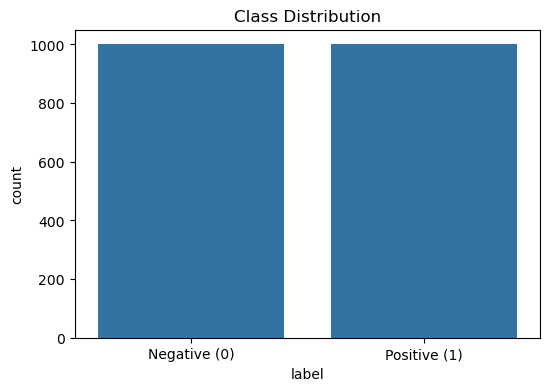

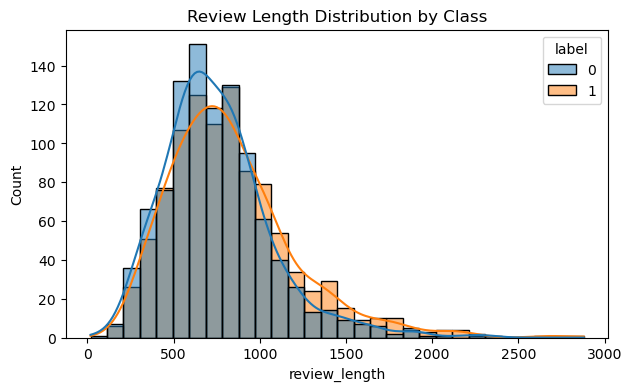

In [ ]:
# TODO: Create visualizations
plt.figure(figsize=(6, 4))
sns.countplot(x=df["label"])
plt.xticks([0, 1], ["Negative (0)", "Positive (1)"])
plt.title("Class Distribution")
plt.show()

plt.figure(figsize=(7, 4))
sns.histplot(data=df, x="review_length", hue="label", bins=30, kde=True)
plt.title("Review Length Distribution by Class")
plt.show()


## 3. Text Preprocessing

### Task 3: Implement Comprehensive Preprocessing

Create a preprocessing pipeline that:

1. Converts to lowercase
2. Removes special characters and numbers
3. Tokenizes text
4. Removes stopwords
5. Applies lemmatization (optional: use stemming instead)
6. Filters out very short tokens (< 3 characters)


In [ ]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
import string

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()


def preprocess_text_basic(text):
    """
    Basic preprocessing: lowercase, tokenize, remove stopwords
    Returns: space-separated tokens string
    """
    # 1) lowercase
    text = text.lower()

    # 2) tokenize
    tokens = word_tokenize(text)

    # 3) remove stopwords + punctuation
    tokens = [
        t for t in tokens
        if t not in stop_words and t not in string.punctuation
    ]

    return " ".join(tokens)


def preprocess_text_advanced(text):
    """
    Advanced preprocessing: + lemmatization, remove numbers/special chars
    Returns: space-separated tokens string
    """
    # 1) lowercase
    text = text.lower()

    # 2) remove numbers + special characters (keep letters + spaces)
    text = re.sub(r"[^a-z\s]", " ", text)

    # 3) tokenize
    tokens = word_tokenize(text)

    # 4) remove stopwords
    tokens = [t for t in tokens if t not in stop_words]

    # 5) lemmatize
    tokens = [lemmatizer.lemmatize(t) for t in tokens]

    # 6) remove empty tokens
    tokens = [t for t in tokens if len(t) > 0]

    return " ".join(tokens)


In [ ]:
# TODO: Test your preprocessing functions
sample_text = "This movie is AMAZING!!! I've watched it 3 times. Best film of 2023! :)"

print("Original:", sample_text)
print("Basic:", preprocess_text_basic(sample_text))
print("Advanced:", preprocess_text_advanced(sample_text))


Original: This movie is AMAZING!!! I've watched it 3 times. Best film of 2023! :)
Basic: movie amazing 've watched 3 times best film 2023
Advanced: movie amazing watched time best film


In [ ]:
# TODO: Apply preprocessing to entire dataset
df["clean_basic"] = df["review"].apply(preprocess_text_basic)
df["clean_advanced"] = df["review"].apply(preprocess_text_advanced)


## 4. Feature Extraction

### Task 4: Extract Multiple Types of Features

Implement feature extraction using scikit-learn:

**A. Bag-of-Words (CountVectorizer)**

- Parameters to experiment with: `max_features`, `min_df`, `max_df`

**B. TF-IDF (TfidfVectorizer)**

- Compare with Bag-of-Words

**C. N-grams**

- Unigrams (1-gram)
- Bigrams (2-gram)
- Trigrams (3-gram)
- Combined (1,2)-grams or (1,3)-grams

**Requirements:**

1. Split data into train/test (80/20)
2. Create at least **4 different feature representations**
3. Print shape and sample features for each representation


In [ ]:
# TODO: Split data into train/test sets
from sklearn.model_selection import train_test_split

# Chọn loại clean text để train
X = df["clean_advanced"]  # nếu bạn dùng advanced
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train size:", len(X_train))
print("Test size:", len(X_test))
print("Train label distribution:\n", y_train.value_counts())


Train size: 1600
Test size: 400
Train label distribution:
 label
1    800
0    800
Name: count, dtype: int64


In [ ]:
# TODO: Feature Extraction Method 1 - Bag of Words
from sklearn.feature_extraction.text import CountVectorizer

bow_vectorizer = CountVectorizer(max_features=5000)
X_train_bow = bow_vectorizer.fit_transform(X_train)
X_test_bow = bow_vectorizer.transform(X_test)

print("BoW Train shape:", X_train_bow.shape)
print("BoW Test shape:", X_test_bow.shape)


BoW Train shape: (1600, 5000)
BoW Test shape: (400, 5000)


In [ ]:
# TODO: Feature Extraction Method 2 - TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print("TF-IDF Train shape:", X_train_tfidf.shape)
print("TF-IDF Test shape:", X_test_tfidf.shape)


TF-IDF Train shape: (1600, 5000)
TF-IDF Test shape: (400, 5000)


In [ ]:
# TODO: Feature Extraction Method 3 - Bigrams
bigram_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(2, 2))
X_train_bigram = bigram_vectorizer.fit_transform(X_train)
X_test_bigram = bigram_vectorizer.transform(X_test)

print("Bigram TF-IDF Train shape:", X_train_bigram.shape)
print("Bigram TF-IDF Test shape:", X_test_bigram.shape)


Bigram TF-IDF Train shape: (1600, 5000)
Bigram TF-IDF Test shape: (400, 5000)


In [ ]:
# TODO: Feature Extraction Method 4 - Combined N-grams
ngram_vectorizer = TfidfVectorizer(max_features=8000, ngram_range=(1, 2))
X_train_ngram = ngram_vectorizer.fit_transform(X_train)
X_test_ngram = ngram_vectorizer.transform(X_test)

print("N-gram (1,2) TF-IDF Train shape:", X_train_ngram.shape)
print("N-gram (1,2) TF-IDF Test shape:", X_test_ngram.shape)


N-gram (1,2) TF-IDF Train shape: (1600, 8000)
N-gram (1,2) TF-IDF Test shape: (400, 8000)


## 5. Model Training and Evaluation

### Task 5: Train Multiple Classifiers

Train and evaluate the following algorithms:

1. **Multinomial Naive Bayes**
2. **Bernoulli Naive Bayes**
3. **Logistic Regression**
4. **Linear SVM (LinearSVC)**
5. **Bonus:** Random Forest or any other classifier

**For each classifier:**

- Train on ALL feature types (BoW, TF-IDF, bigrams, n-grams)
- Calculate metrics: Accuracy, Precision, Recall, F1-score
- Record training time
- Store results in a structured format (dictionary or DataFrame)


In [ ]:
# TODO: Import classifiers
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
import time


In [ ]:
# TODO: Create a function to train and evaluate a model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


def train_and_evaluate(model, X_train, X_test, y_train, y_test, model_name, feature_name):
    """
    Train a model and return evaluation metrics

    Args:
        model: sklearn classifier
        X_train, X_test: feature matrices
        y_train, y_test: labels
        model_name: name of the model (str)
        feature_name: name of feature type (str)

    Returns:
        dict: Dictionary containing all metrics
    """
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    return {
        "Model": model_name,
        "Feature": feature_name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, zero_division=0),
        "Recall": recall_score(y_test, y_pred, zero_division=0),
        "F1": f1_score(y_test, y_pred, zero_division=0),
        "model_obj": model,
        "y_pred": y_pred
    }
    pass


In [ ]:
# TODO: Train all models on all feature types

results = []

models = {
    'Multinomial NB': MultinomialNB(),
    'Bernoulli NB': BernoulliNB(),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Linear SVM': LinearSVC(max_iter=1000)
}

feature_sets = {
    'Bag-of-Words': (X_train_bow, X_test_bow),
    'TF-IDF': (X_train_tfidf, X_test_tfidf),
    'Bigrams': (X_train_bigram, X_test_bigram),
    'N-grams': (X_train_ngram, X_test_ngram)
}

# Loop through all combinations of models and features
# Use train_and_evaluate function
# Append results to list

# Convert results to DataFrame for easy analysis
# results_df = pd.DataFrame(results)


### Task 6: Results Analysis and Visualization

**Requirements:**

1. Create a comprehensive results table showing all metrics
2. Identify the best model for each feature type
3. Identify the best overall model
4. Create visualizations:
   - Bar chart comparing accuracy across models and features
   - Heatmap of F1-scores (models × features)
   - Training time comparison
5. Display confusion matrix for the best model


In [ ]:
# TODO: Display comprehensive results table
results_df = pd.DataFrame(results)
results_df.sort_values(by="F1", ascending=False)


KeyError: 'F1'

In [ ]:
# TODO: Find best models
best_model = results_df.loc[results_df["F1"].idxmax()]
print("Best Model:")
print(best_model)


Best Model:
Model                                               Linear SVM
Feature                                           Bag-of-Words
Accuracy                                                0.8625
Precision                                             0.850242
Recall                                                    0.88
F1                                                    0.864865
model_obj                                          LinearSVC()
y_pred       [0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, ...
Name: 12, dtype: object


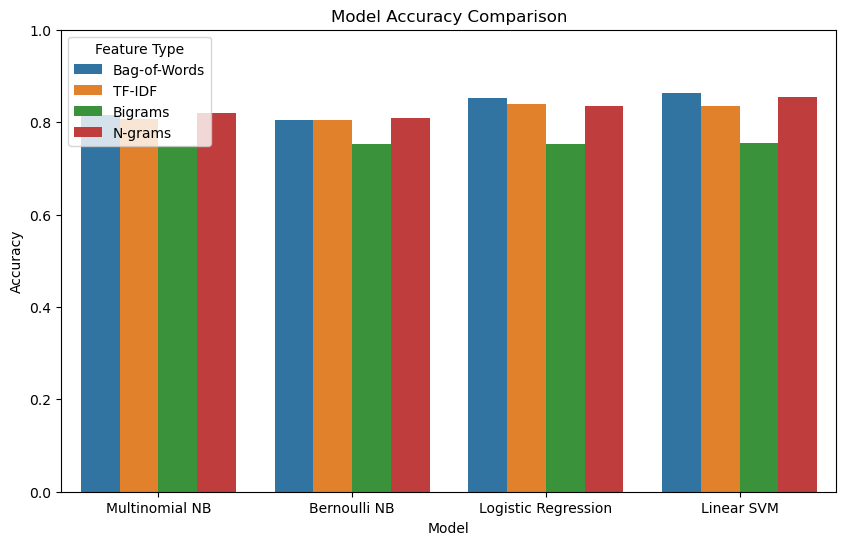

In [ ]:
# TODO: Create visualization 1 - Accuracy comparison
plt.figure(figsize=(10, 6))
sns.barplot(
    data=results_df,
    x="Model",
    y="Accuracy",
    hue="Feature"
)
plt.title("Model Accuracy Comparison")
plt.ylim(0, 1)
plt.legend(title="Feature Type")
plt.show()


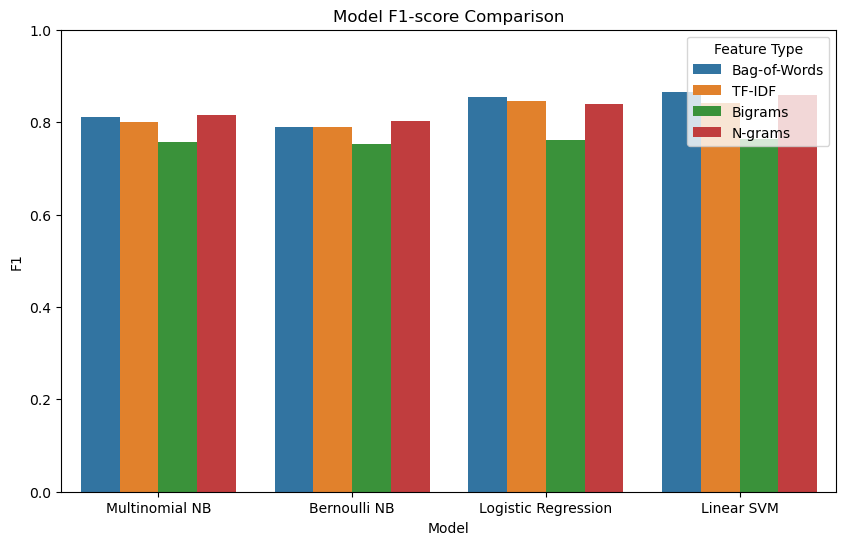

In [ ]:
# TODO: Create visualization 2 - F1-score
plt.figure(figsize=(10, 6))
sns.barplot(
    data=results_df,
    x="Model",
    y="F1",
    hue="Feature"
)
plt.title("Model F1-score Comparison")
plt.ylim(0, 1)
plt.legend(title="Feature Type")
plt.show()


Best Model:
Model                                               Linear SVM
Feature                                           Bag-of-Words
Accuracy                                                0.8625
Precision                                             0.850242
Recall                                                    0.88
F1                                                    0.864865
model_obj                                          LinearSVC()
y_pred       [0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, ...
Name: 12, dtype: object


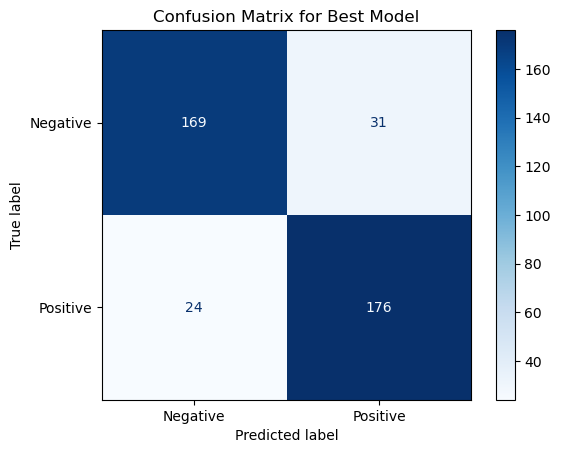

In [ ]:
# TODO: Display confusion matrix for best model

from sklearn.metrics import ConfusionMatrixDisplay

# Retrain best model and display confusion matrix with visualization
best_model = results_df.loc[results_df["F1"].idxmax()]
print("Best Model:")
print(best_model)
best_model_obj = best_model["model_obj"]
best_y_pred = best_model["y_pred"]
cm = confusion_matrix(y_test, best_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[
                              "Negative", "Positive"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Best Model")
plt.show()


## 6. Error Analysis

### Task 7: Analyze Misclassifications

**Requirements:**

1. Find all misclassified examples from the best model
2. Categorize errors:
   - False Positives (predicted positive, actually negative)
   - False Negatives (predicted negative, actually positive)
3. Display at least 10 examples from each category
4. Analyze patterns:
   - Are there common words in misclassified reviews?
   - Is there a relationship between review length and errors?
5. Create visualizations:
   - Length distribution of correct vs incorrect predictions
   - Word cloud of misclassified reviews


In [ ]:
# TODO: Get predictions from best model
best_model = results_df.loc[results_df["F1"].idxmax()]
best_model_obj = best_model["model_obj"]
# best_y_pred = best_model_obj.predict(X_test_ngram)  # Example for n-gram features


In [ ]:
# TODO: Find and categorize misclassifications
misclassified_indices = np.where(best_y_pred != y_test)[0]
misclassified_reviews = X_test.iloc[misclassified_indices]
misclassified_true = y_test.iloc[misclassified_indices]
misclassified_pred = best_y_pred[misclassified_indices]
misclassified_df = pd.DataFrame({
    "Review": misclassified_reviews,
    "True Label": misclassified_true,
    "Predicted Label": misclassified_pred
})


In [ ]:
# TODO: Analyze error patterns

# Count misclassifications
misclassified_count = misclassified_df.shape[0]
print(f"Number of misclassified samples: {misclassified_count}")

# Analyze error patterns
error_patterns = misclassified_df.groupby(
    ["True Label", "Predicted Label"]).size()
print("Error Patterns:")
print(error_patterns)


Number of misclassified samples: 55
Error Patterns:
True Label  Predicted Label
0           1                  31
1           0                  24
dtype: int64


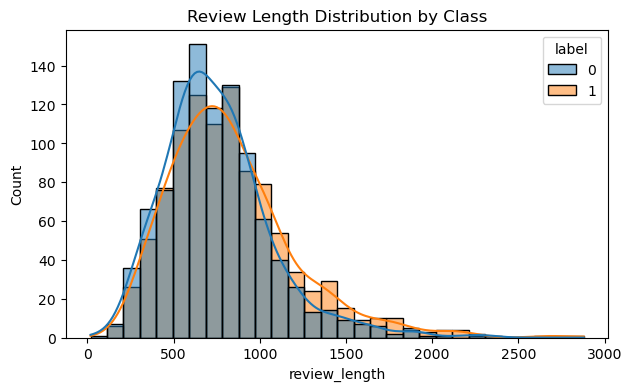

In [ ]:
# TODO: Visualization - Length distribution
plt.figure(figsize=(7, 4))
sns.histplot(data=df, x="review_length", hue="label", bins=30, kde=True)
plt.title("Review Length Distribution by Class")
plt.show()


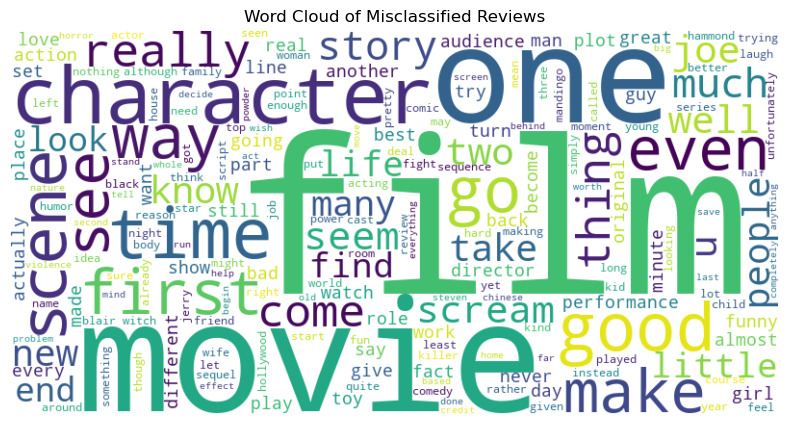

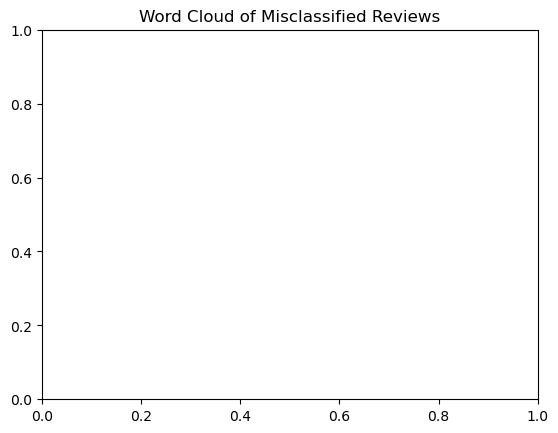

In [ ]:
# TODO: Visualization - Word cloud of misclassified reviews

from wordcloud import WordCloud
all_misclassified_text = " ".join(misclassified_df["Review"])
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(
    all_misclassified_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Misclassified Reviews")
plt.show()
plt.title("Word Cloud of Misclassified Reviews")
plt.show()
